In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq \*.zip
%rm *.zip

 98% 533M/543M [00:04<00:00, 109MB/s]
100% 543M/543M [00:04<00:00, 130MB/s]
 98% 266M/271M [00:03<00:00, 61.5MB/s]
100% 271M/271M [00:03<00:00, 71.6MB/s]
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A

2 archives were successfully processed.


In [0]:
# Only will work with 1000 samples by class and 400 aditional samples from each class as validation data
%%bash
mkdir -p data/train/dogs data/train/cats data/validation/dogs data/validation/cats
find train -name 'dog.*' | head -1400 | xargs -I filename mv filename data/train/dogs
find train -name 'cat.*' | head -1400 | xargs -I filename mv filename data/train/cats

0

In [0]:
%%bash
cd /content/gdrive/My Drive/Kaggle/Dogs vs Cats/data/train/dogs
ls | tail -400 | xargs -I filename mv filename ../../validation/dogs
cd /content/gdrive/My Drive/Kaggle/Dogs vs Cats/data/train/cats
ls | tail -400 | xargs -I filename mv filename ../../validation/cats
cd /content/gdrive/My Drive/Kaggle/Dogs vs Cats

/content/gdrive/My Drive/Kaggle/Dogs vs Cats/data/train/dogs
/content/gdrive/My Drive/Kaggle/Dogs vs Cats/data/train/cats
/content/gdrive/My Drive/Kaggle/Dogs vs Cats


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [0]:
# build model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout

# load the VGG16 network, ensuring the head fully connected layer sets are left
model_vgg16_conv = VGG16(weights="imagenet", include_top=False)
# Make vgg16 model layers as non trainable
for layer in model_vgg16_conv.layers:
    layer.trainable = False

input = Input(shape=input_shape)
# use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

top_model = Flatten()(output_vgg16_conv)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

model = Model(inputs=input, outputs=top_model)

In [0]:
learning_rate = 1e-4
momentum = 0.9

from keras.optimizers import SGD

model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=learning_rate, momentum=momentum),
    metrics=['accuracy']
)

In [0]:
# train augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# for testing only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow_from_directory(
  'data/train',
  target_size=(150, 150),
  batch_size=batch_size,
  class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
  'data/validation',
  target_size=(150, 150),
  batch_size=batch_size,
  class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [0]:
epochs = 50

history = model.fit_generator(
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=epochs,
  validation_data=validation_generator,
  validation_steps=nb_validation_samples // batch_size
)

Epoch 1/50
125/125 [==============================] - 29s 230ms/step - loss: 0.6734 - accuracy: 0.6080 - val_loss: 0.5860 - val_accuracy: 0.7987
Epoch 2/50
125/125 [==============================] - 22s 175ms/step - loss: 0.5670 - accuracy: 0.6990 - val_loss: 0.5605 - val_accuracy: 0.8125
Epoch 3/50
125/125 [==============================] - 22s 178ms/step - loss: 0.5171 - accuracy: 0.7520 - val_loss: 0.5105 - val_accuracy: 0.8213
Epoch 4/50
125/125 [==============================] - 22s 176ms/step - loss: 0.4764 - accuracy: 0.7780 - val_loss: 0.5856 - val_accuracy: 0.8300
Epoch 5/50
125/125 [==============================] - 22s 173ms/step - loss: 0.4614 - accuracy: 0.7875 - val_loss: 0.4041 - val_accuracy: 0.8338
Epoch 6/50
125/125 [==============================] - 22s 175ms/step - loss: 0.4489 - accuracy: 0.8000 - val_loss: 0.5647 - val_accuracy: 0.8413
Epoch 7/50
125/125 [==============================] - 22s 176ms/step - loss: 0.4284 - accuracy: 0.8130 - val_loss: 0.4764 - val_ac

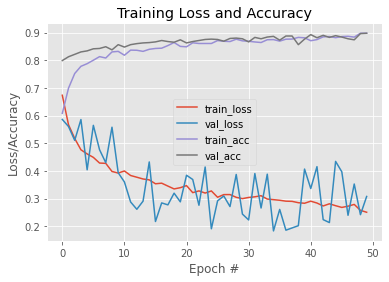

In [0]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")